<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/eigen_cam_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8d9607363083be01eb09a1f7f30e90be46ec66baecefbbb71119ecca4fb82f76
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import torch
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from efficientnet_pytorch import EfficientNet

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define transformations, including grayscale and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the root directory of your train and test data in Google Drive
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]


class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label
# Load your custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
import torchvision.models as model
dir(model)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [8]:
# Load Efficientnet model
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, 7)  # Set the number of classes
efficientnet_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/efficientnet_model.pth')
efficientnet_model.eval()
efficientnet_model.to(device)

Loaded pretrained weights for efficientnet-b0


<ipython-input-8-8ac9330f770c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/efficient

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [9]:
class EigenGradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize the EigenGradCAM object.
        :param model: The PyTorch model for which Grad-CAM is applied.
        :param target_layer: The layer in the model where gradients are computed.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handlers = []
        self._register_hooks()

    def _register_hooks(self):
        """
        Register hooks to capture gradients and activations at the target layer.
        """
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handlers.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handlers.append(self.target_layer.register_backward_hook(backward_hook))

    def _compute_eigen_cam(self):
        """
        Perform Eigen decomposition on the gradients to compute the EigenCAM.
        """
        b, k, u, v = self.gradients.size()  # Get gradient dimensions
        weights = self.gradients.view(b, k, -1).mean(dim=2)  # Mean along spatial dimensions

        # Weighted sum of activations (use einsum for batch-wise operations)
        cam = torch.einsum('bk,bkij->bij', weights, self.activations)  # Weighted sum of activations
        cam = cam.clamp(min=0)  # ReLU to retain only positive influence

        # Perform SVD decomposition for EigenCAM emphasis
        cam_flattened = cam.view(cam.size(0), -1)  # Flatten the CAM for SVD
        u, s, vh = torch.linalg.svd(cam_flattened, full_matrices=False)

        # Apply the first singular vector and value to the flattened CAM
        # and reshape it to the original dimensions
        cam = (u[:, 0].unsqueeze(1) * s.unsqueeze(1) * vh).view(cam.size(0), cam.size(1), cam.size(2))
        # Instead of using just the first singular value, reconstruct the CAM
        # using the first singular vector (u[:, 0]), singular value (s), and
        # the right singular vectors (vh)


        return cam

    def generate(self, input_tensor, target_class=None):
        """
        Generate the EigenCAM heatmap.
        :param input_tensor: The input tensor to the model.
        :param target_class: The class index to target (optional).
        :return: The EigenCAM heatmap.
        """
        self.model.zero_grad()
        output = self.model(input_tensor)

        # If no target_class is provided, use the predicted class
        if target_class is None:
            target_class = output.argmax(dim=1)

        # Compute gradients w.r.t the target class
        one_hot_output = torch.zeros_like(output)
        one_hot_output[range(output.size(0)), target_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute the EigenCAM heatmap
        cam = self._compute_eigen_cam()
        cam = F.interpolate(cam.unsqueeze(1), size=input_tensor.shape[2:], mode='bilinear', align_corners=False).squeeze()
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.cpu().numpy()

    def __del__(self):
        for handler in self.hook_handlers:
            handler.remove()

In [10]:
image_folder = '/content/drive/MyDrive/FER_Images'

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# Initialize EigenGradCAM for the target layer
target_layer_name = '_conv_head'
target_layer = getattr(efficientnet_model, target_layer_name)
eigen_cam = EigenGradCAM(model=efficientnet_model, target_layer=target_layer)

In [14]:
emotion_images = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
results = {}

for emotion in emotion_images:
    img_path = os.path.join(image_folder, f"{emotion}.png")
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get EigenGradCAM heatmap
    eigen_cam_map = eigen_cam.generate(input_tensor)

    # Convert the original and heatmap to numpy for plotting
    original_img = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * eigen_cam_map), cv2.COLORMAP_INFERNO)
    heatmap_overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Store images for visualization
    results[emotion] = (original_img, heatmap_overlay, heatmap)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


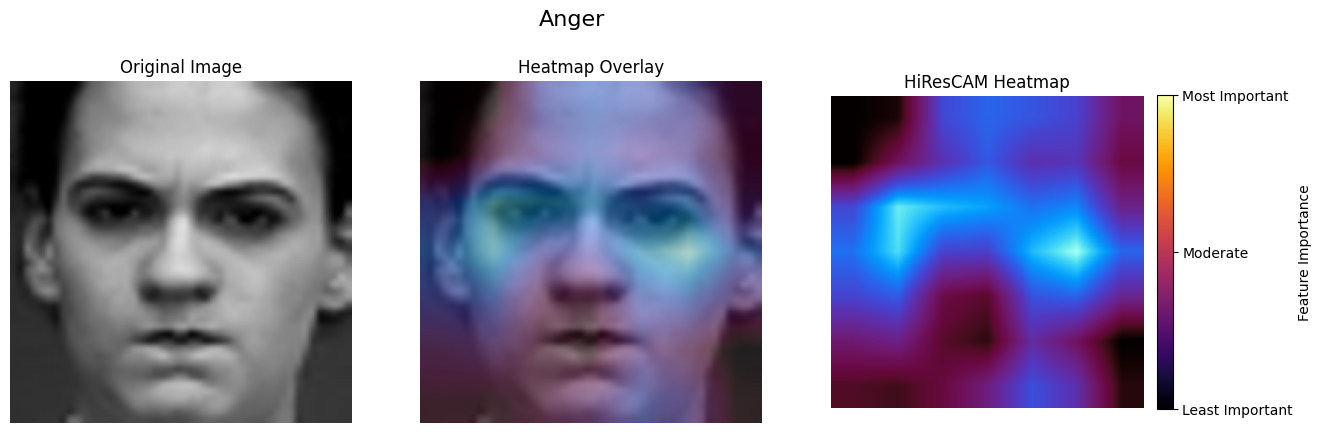

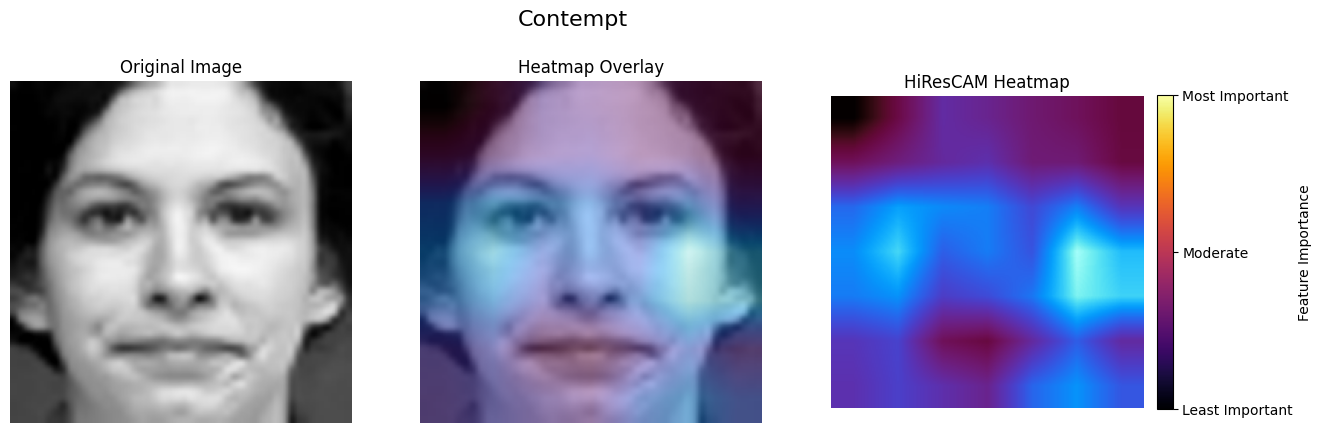

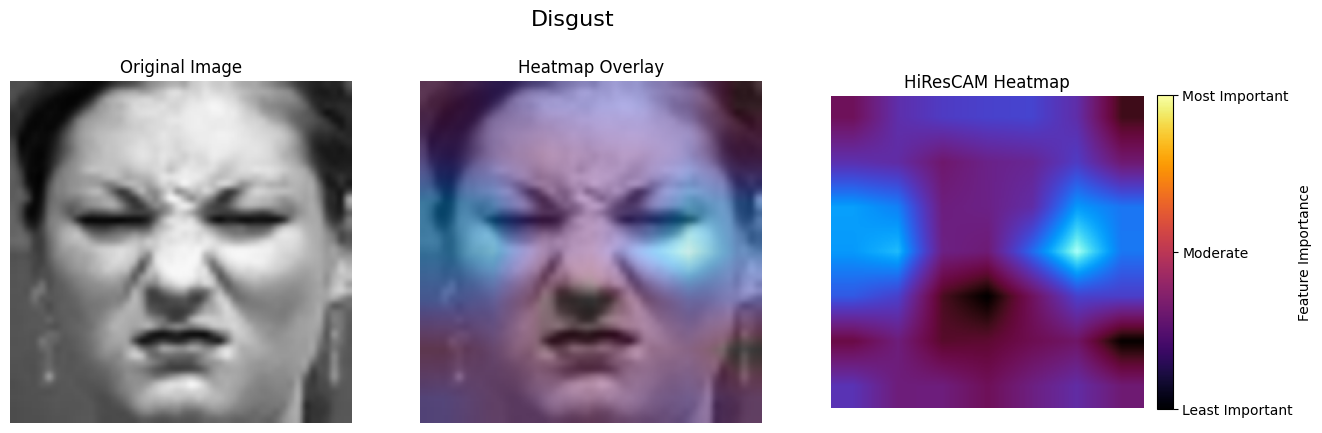

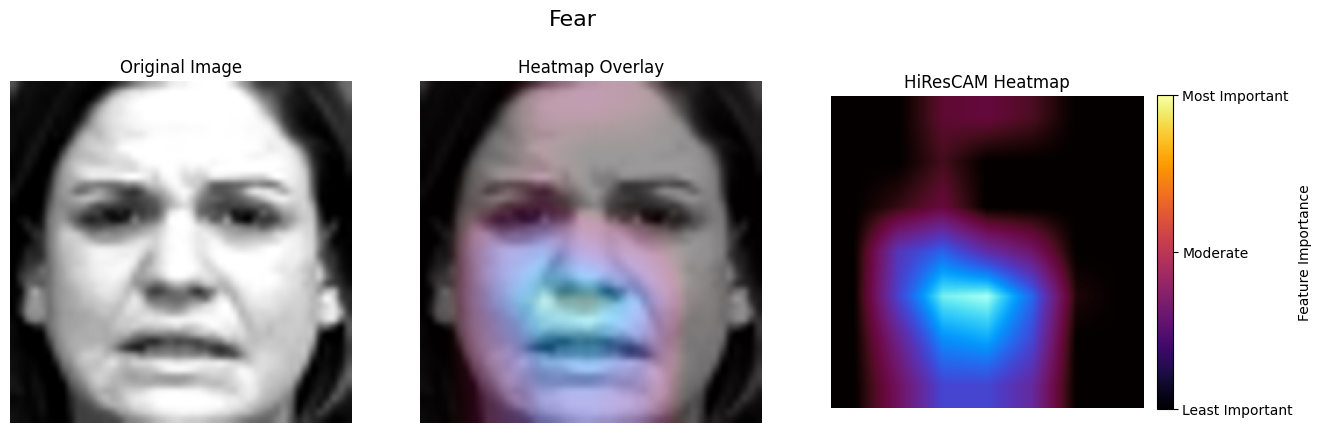

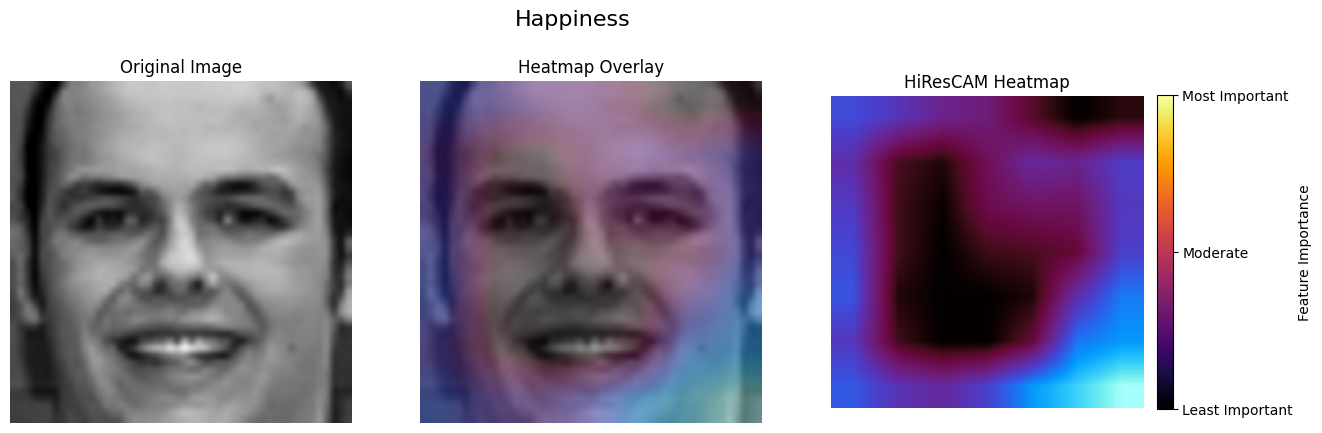

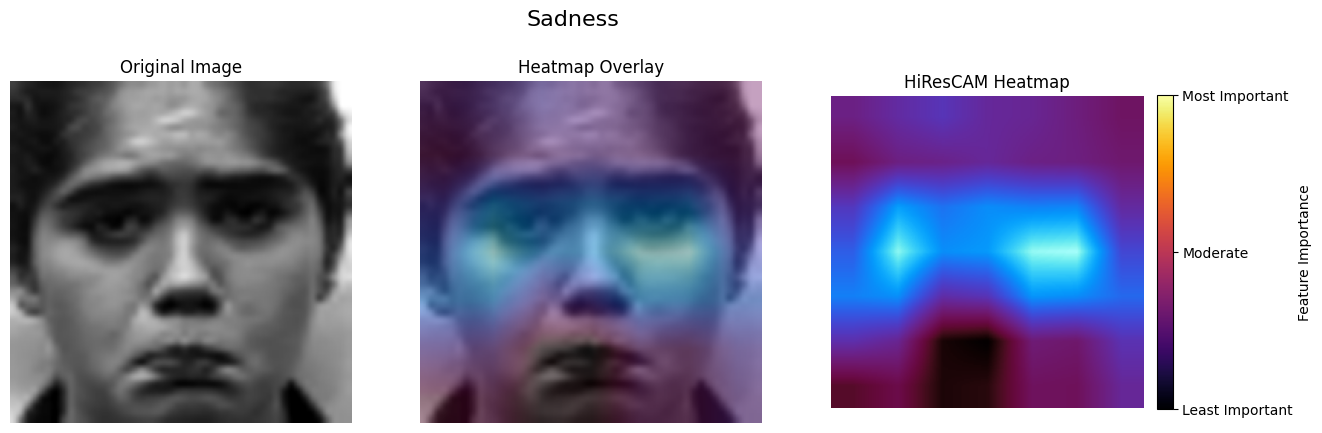

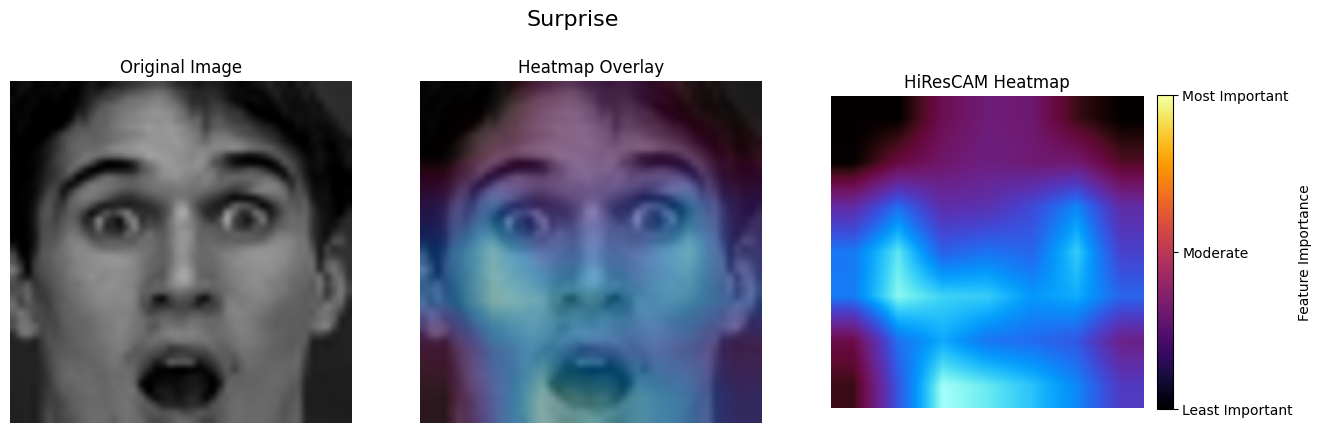

In [15]:
# Plotting with colorbar
for emotion, (original_img, heatmap_overlay, heatmap) in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(emotion.capitalize(), fontsize=16)

    # Original Image
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Heatmap Overlay
    ax[1].imshow(heatmap_overlay)
    ax[1].set_title('Heatmap Overlay')
    ax[1].axis('off')

    # Standalone Heatmap with Colorbar (using 'inferno' colormap)
    heatmap_img = ax[2].imshow(heatmap, cmap='inferno')
    ax[2].set_title('HiResCAM Heatmap')
    ax[2].axis('off')

    # Add colorbar matching the 'inferno' colormap
    cbar = fig.colorbar(heatmap_img, ax=ax[2], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Importance')
    cbar.set_ticks([0, 127.5, 255])
    cbar.set_ticklabels(['Least Important', 'Moderate', 'Most Important'])

    plt.show()